# <font color="#CA3532">Introducción a TensorFlow (parte II)</font>

Clasificación multiclase. Ejemplo detallado con el problema Iris.

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

2025-05-27 13:16:08.946891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 13:16:10.130259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## <font color="#CA3532">Carga de los datos del problema Iris</font>

Vamos a empezar con un problema muy sencillo, uno de los problemas de clasificación más famosos que existen. Fue propuesto por R.A. Fisher en 1936, y consiste en clasificar plantas de la especie *Iris* en tres subespecies: *iris-virginica*, *iris-setosa* e *iris-versicolor*. Los atributos que describen cada planta son las dimensiones (longitud y anchura) del pétalo y el sépalo. El conjunto de datos contiene un total de 150 plantas, 50 de cada una de las clases.

En la siguiente celda cargamos los datos del problema, que están incluidos en el paquete *sklearn.datasets*. En este enlace tienes una descripción de los datos:

https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset


In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

La variable ``iris`` es un diccionario con los siguientes elementos:

- ``data``: array de numpy con los datos del problema (no incluye la clase). Cada fila es un ejemplo (150), cada columna es un atributo (4).
- ``target``: array de numpy con las clases de los 150 ejemplos, cada clase es un número entre 0 y 2.
- ``target_names``: array de numpy con los nombres de las 3 clases.
- ``DESCR``: string con una descripción del problema.
- ``feature_names``: lista con los nombres de los 4 atributos.
- ``filename``: nombre del fichero que contiene los datos.

### <font color="#CA3532">Visualización de los datos</font>

Creamos un DataFrame con los datos para que sea más fácil visualizarlos:

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
df['target_num'] = iris.target
df[::10].head(15)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_num
0,5.1,3.5,1.4,0.2,setosa,0
10,5.4,3.7,1.5,0.2,setosa,0
20,5.4,3.4,1.7,0.2,setosa,0
30,4.8,3.1,1.6,0.2,setosa,0
40,5.0,3.5,1.3,0.3,setosa,0
50,7.0,3.2,4.7,1.4,versicolor,1
60,5.0,2.0,3.5,1.0,versicolor,1
70,5.9,3.2,4.8,1.8,versicolor,1
80,5.5,2.4,3.8,1.1,versicolor,1
90,5.5,2.6,4.4,1.2,versicolor,1


Y mostramos la distribución de las clases en el plano definido por cada pareja de atributos. Como vemos el problema no es muy complicado. Una de las clases (setosa) está completamente separada de las otras dos. Las dos últimas solapan ligeramente.

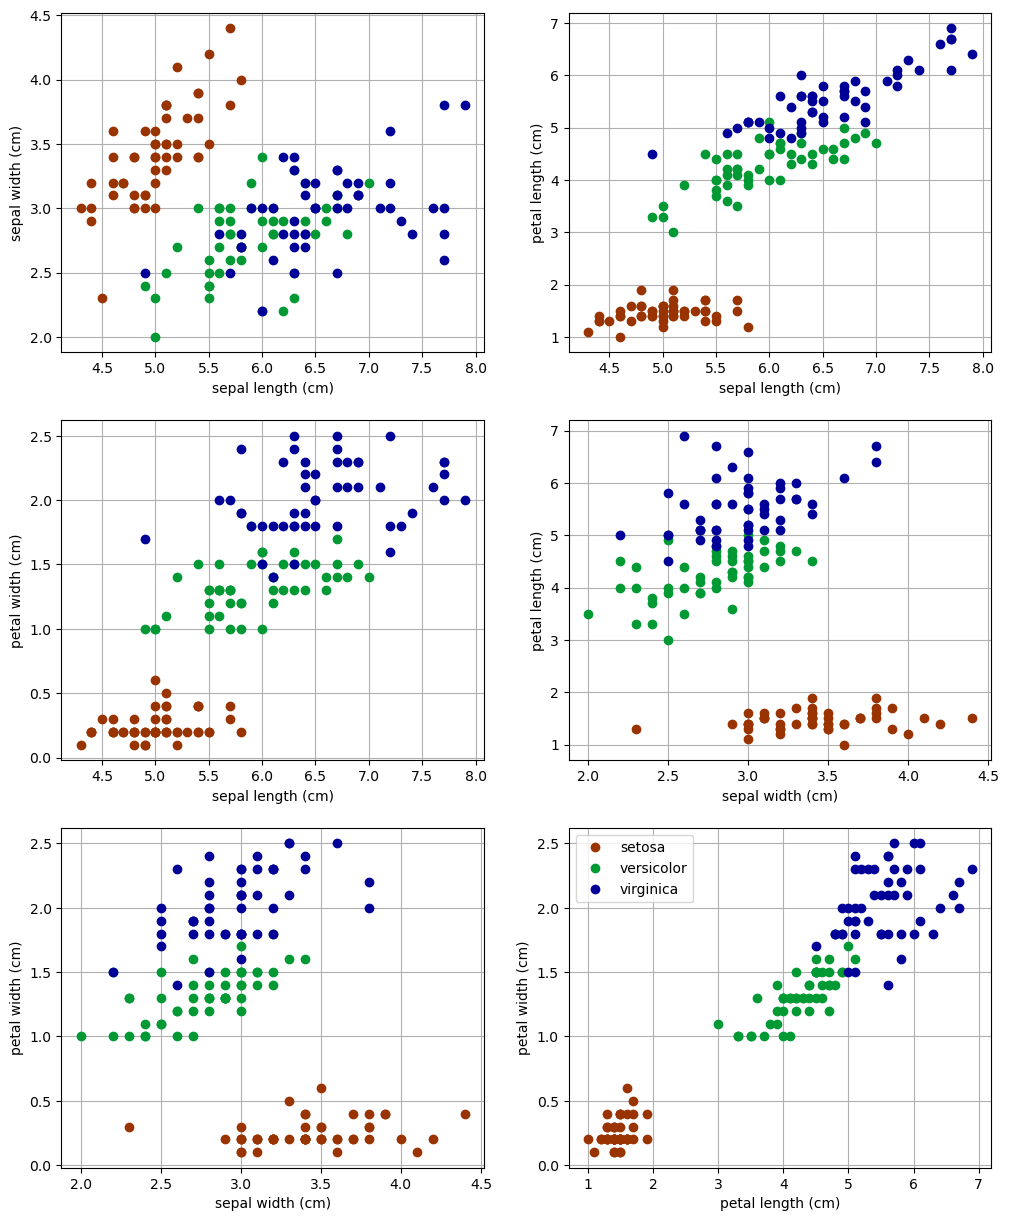

In [4]:
plt.figure(figsize=(12,15))
n_classes = 3
plot_colors = "bry"

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    plt.subplot(3, 2, pairidx + 1)
    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.grid(True)

    plt.plot(X[y==0,0], X[y==0,1], 'o', label=iris.target_names[0], color='#993300')
    plt.plot(X[y==1,0], X[y==1,1], 'o', label=iris.target_names[1], color='#009933')
    plt.plot(X[y==2,0], X[y==2,1], 'o', label=iris.target_names[2], color='#000099')

plt.legend(loc=2)
plt.show()

### <font color="#CA3532">Preparación de los datos</font>

Vamos a considerar sólo las dos últimas dimensiones del problema (la longitud y la anchura del pétalo). Esto nos permitirá visualizar el modelo en 2D.

A continuación generamos los arrays de datos ``x`` y ``t``:

In [5]:
x = iris.data[:, -2:]
t = iris.target
[n, d] = x.shape

Los datos del problema están ordenados (los primeros 50 ejemplos son de la clase setosa, los 50 siguientes de la clase versicolor, y los 50 últimos de la clase virginica). Para evitar sesgos durante el entrenamiento del modelo conviene desordenarlos:

In [6]:
p = np.random.permutation(n)
x = x[p, :]
t = t[p]

Finalmente trasponemos la variable ``x`` para que tenga dimensiones ``2x150`` e introducimos una dimensión *dummy* en la variable ``t`` para que tenga dimensiones ``1x150``.

In [7]:
x = x.T
t = t[None, :]
print("Dimension de x:", x.shape)
print("Dimension de t:", t.shape)

Dimension de x: (2, 150)
Dimension de t: (1, 150)


La figura siguiente muestra los datos del problema:

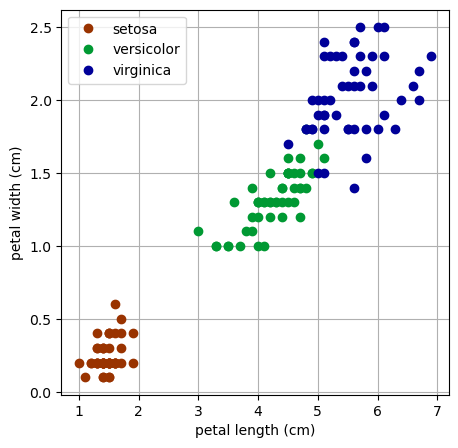

In [8]:
plt.figure(figsize=(5, 5))

plt.plot(x[0, t.ravel()==0], x[1, t.ravel()==0], 'o', label=iris.target_names[0], color='#993300')
plt.plot(x[0, t.ravel()==1], x[1, t.ravel()==1], 'o', label=iris.target_names[1], color='#009933')
plt.plot(x[0, t.ravel()==2], x[1, t.ravel()==2], 'o', label=iris.target_names[2], color='#000099')

plt.xlabel(iris.feature_names[pair[0]])
plt.ylabel(iris.feature_names[pair[1]])
plt.grid(True)

plt.legend(loc=2)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Particion entrenamiento-test:
x_train, x_test, t_train, t_test = train_test_split(x.T, t.T, test_size=0.33, random_state=12)

# Estandarizacion:
means = x_train.mean(axis=0)
stds = x_train.std(axis=0)
x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

In [11]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(100, 2)
(100, 1)
(50, 2)
(50, 1)


## <font color="#CA3532">Estrategia One-vs-rest</font>

Para aquellos modelos más sencillos, como la regresión logística que hemos visto, una alternativa para construir un modelo de decisión multiclase es utilizar la estrategia **One-vs-rest**.

La estrategia consiste en construir N modelos para que cada uno aprenda a identificar cada una de las N clases por separado, diferenciándolas de los demás. Una vez los modelos se han entrenado **con los mismos hiperparámetros**, se normalizan las predicciones para dar la clase con mayor probabilidad.

### <font color="#CA3532">Definición del modelo</font>

In [12]:
class LogisticRegressionModel:

  def __init__(self, d0=2):
    self.W = tf.Variable(tf.random.normal(shape=[d0, 1], dtype=tf.dtypes.float64))
    self.b = tf.Variable(tf.random.normal(shape=[1], dtype=tf.dtypes.float64))

  def predict(self, x):
    """
    x must be a (n,d0) array
    returns a (n,1) array with the predictions for each of the n patterns
    """
    z = x @ self.W + self.b
    y = tf.sigmoid(z)
    return y

  def loss(self, x, t):
    """
    computes the cross-entropy between the model predictions and the targets
    """
    y = self.predict(x)
    loss = tf.reduce_mean(-t*tf.math.log(y) - (1.-t)*tf.math.log(1.-y))
    return loss

  def fit(self, x, t, eta, num_epochs):
    """
    Fits the model parameters with data (x, t) using a learning rate eta and
    num_epochs epochs
    """
    loss_history = []
    for epoch in range(num_epochs):
      with tf.GradientTape() as tape:
        loss = self.loss(x, t)

      loss_history.append(loss)

      [db, dW] = tape.gradient(loss, [self.b, self.W])
      self.b.assign(self.b - eta*db)
      self.W.assign(self.W - eta*dW)

    return loss_history

  def accuracy(self, x, t):
    y = self.predict(x).numpy()
    pred = y > 0.5
    return np.mean(pred == t)

Una vez definida la clase *LogisticRegressionModel*, voy a definir una clase *MulticlassLogisticRegressionModel*. Esta clase tiene que hacer lo siguiente:

- Tener un conjunto de modelos de tipo *LogisticRegressionModel*, tantos como clases diferentes a clasificar haya en el problema (en el ejemplo que estamos viendo, son 3 clases: setosa, versicolor y virginica).

- Entrenar el modelo multiclase significa entrenar cada modelo con cada clase a pares, es decir, el modelo 0 debe entrenarse para diferenciar la clase 0 de las demás; el modelo 1 debe entrenarse para diferenciar la clase 1 de las demás; y el modelo 2 debe entrenarse para diferenciar la clase 2 de las demás.

- Predecir el resultado final debe dar la probabilidad que la combinación de los tres modelos da a cada clase. Para ello, lo que vamos a hacer es normalizar las probabilidades siguiendo la siguiente ecuación:

$$P(clase=i)(x) = \frac{P_{modelo=i}(clase=i)(x)}{\sum_{j=0}^{j=N\_clases}{P_{modelo=j}(clase=j)(x)}}$$

Donde $P_{modelo=i}(clase=i)(x)$ es la probabilidad que el modelo asociado a la clase $i$ da al dato $x$ de pertenecer a la clase $i$ frente a las demás.

In [13]:
class MulticlassLogisticRegressionModel:

  def __init__(self, input_dimension, num_classes):
    self.models = [LogisticRegressionModel(input_dimension) for _ in range(num_classes)]
    self.num_classes = num_classes

  def fit(self, x, t, eta, num_epochs):
    for id_class, model in enumerate(self.models):
      t_class = (t == id_class) * 1
      model.fit(x, t_class, eta, num_epochs)

  def predict(self, x):
    preds = np.zeros((x.shape[0], self.num_classes))
    for id_class, model in enumerate(self.models):
      preds[:, id_class] = model.predict(x)[:, 0]
    preds /= preds.sum(axis=1, keepdims=True)
    return preds

  def accuracy(self, x, t):
    preds = self.predict(x)
    y = np.argmax(preds, axis=1)[:, None]
    print(y.shape)
    return np.mean(y == t)

### <font color="#CA3532">Entrenamiento</font>

In [14]:
# Construccion del modelo
n, d = x_train.shape
num_clases = len(np.unique(t_train))

model = MulticlassLogisticRegressionModel(d, num_clases)

# Entrenamiento del modelo
eta = 0.8
epochs = 200

model.fit(x_train, t_train, eta, epochs)

2025-05-27 13:16:13.428369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-27 13:16:13.783153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-27 13:16:13.783961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
preds_train = model.predict(x_train)
preds_test = model.predict(x_test)

In [16]:
print("Accuracy (train):", model.accuracy(x_train, t_train))
print("Accuracy (test):", model.accuracy(x_test, t_test))

(100, 1)
Accuracy (train): 0.95
(50, 1)
Accuracy (test): 0.8


### <font color="#CA3532">Visualización del modelo</font>

Pintamos la decisión global del modelo One-vs-rest:

(1295, 3)


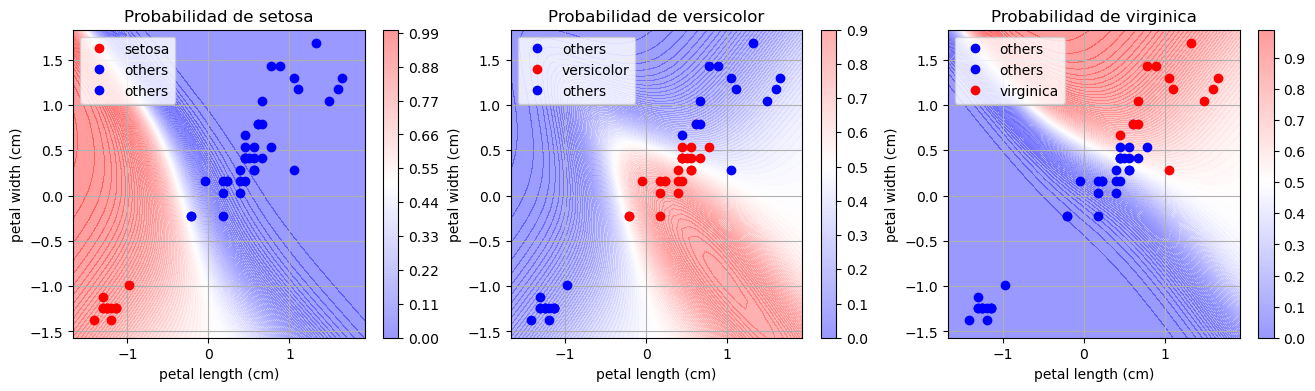

In [17]:
xx, yy = np.meshgrid(np.arange(x_train[:, 0].min()-0.2, x_train[:, 0].max()+0.2, 0.1),
                     np.arange(x_train[:, 1].min()-0.2, x_train[:, 1].max()+0.2, 0.1))
xy = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])],axis=0).T
z = model.predict(xy)
print(z.shape)

plt.figure(figsize=(16, 4))

for clase_objetivo in [0, 1, 2]:
  plt.subplot(1, 3, clase_objetivo+1)
  plt.contourf(xx, yy, z[:, clase_objetivo].reshape(xx.shape), 100, cmap="bwr", alpha=0.4, vmin=0.0, vmax=1.0)

  plt.plot(x_test[t_test.ravel()==0, 0], x_test[t_test.ravel()==0, 1], 'o', label=iris.target_names[0] if clase_objetivo == 0 else 'others', color='red' if clase_objetivo == 0 else 'blue')
  plt.plot(x_test[t_test.ravel()==1, 0], x_test[t_test.ravel()==1, 1], 'o', label=iris.target_names[1] if clase_objetivo == 1 else 'others', color='red' if clase_objetivo == 1 else 'blue')
  plt.plot(x_test[t_test.ravel()==2, 0], x_test[t_test.ravel()==2, 1], 'o', label=iris.target_names[2] if clase_objetivo == 2 else 'others', color='red' if clase_objetivo == 2 else 'blue')

  plt.title("Probabilidad de %s" % (iris.target_names[clase_objetivo]))
  plt.xlabel(iris.feature_names[pair[0]])
  plt.ylabel(iris.feature_names[pair[1]])
  plt.grid(True)

  plt.legend(loc=2)
  plt.colorbar()

plt.show()

Ahora pintamos la frontera de decisión de cada uno de los modelos que componen el modelo global One-vs-rest:

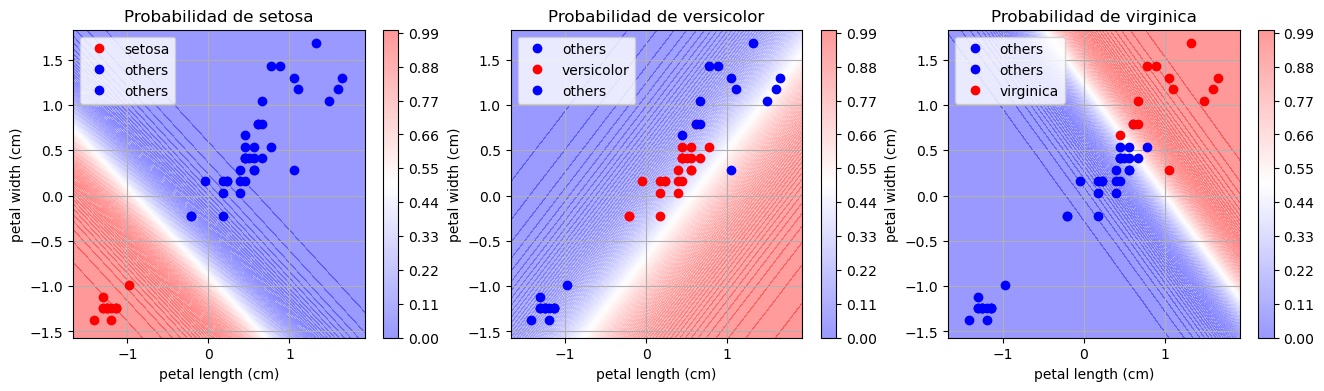

In [18]:
plt.figure(figsize=(16, 4))
for clase_objetivo, m in enumerate(model.models):
  xx, yy = np.meshgrid(np.arange(x_train[:, 0].min()-0.2, x_train[:, 0].max()+0.2, 0.1),
                     np.arange(x_train[:, 1].min()-0.2, x_train[:, 1].max()+0.2, 0.1))
  xy = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])],axis=0).T
  z = m.predict(xy).numpy()

  plt.subplot(1, 3, clase_objetivo+1)
  plt.contourf(xx, yy, z.reshape(xx.shape), 100, cmap="bwr", alpha=0.4, vmin=0.0, vmax=1.0)

  plt.plot(x_test[t_test.ravel()==0, 0], x_test[t_test.ravel()==0, 1], 'o', label=iris.target_names[0] if clase_objetivo == 0 else 'others', color='red' if clase_objetivo == 0 else 'blue')
  plt.plot(x_test[t_test.ravel()==1, 0], x_test[t_test.ravel()==1, 1], 'o', label=iris.target_names[1] if clase_objetivo == 1 else 'others', color='red' if clase_objetivo == 1 else 'blue')
  plt.plot(x_test[t_test.ravel()==2, 0], x_test[t_test.ravel()==2, 1], 'o', label=iris.target_names[2] if clase_objetivo == 2 else 'others', color='red' if clase_objetivo == 2 else 'blue')

  plt.title("Probabilidad de %s" % (iris.target_names[clase_objetivo]))
  plt.xlabel(iris.feature_names[pair[0]])
  plt.ylabel(iris.feature_names[pair[1]])
  plt.grid(True)

  plt.legend(loc=2)
  plt.colorbar()

plt.show()

## <font color="#CA3532">Modelo multiclase: Red neuronal</font>

### <font color="#CA3532">Definición del modelo</font>

In [19]:
class NeuralNetworkModel:

  def __init__(self, layers_size=[2]):
    self.W = [tf.Variable(tf.random.normal(shape=[a, b], dtype=tf.dtypes.float64)) for a, b in zip(layers_size[:-1], layers_size[1:])]
    self.b = [tf.Variable(tf.random.normal(shape=[1, b], dtype=tf.dtypes.float64)) for b in layers_size[1:]]

  def predict_pre_activation(self, x):
    """
    x must be a (n,d0) array
    returns a (n,num_clases) array with the pre-activations for each of the n patterns
    """
    y = x
    for w, b in zip(self.W[:-1], self.b[:-1]):
      z = y @ w + b
      y = tf.sigmoid(z)

    z = y @ self.W[-1] + self.b[-1]

    return z

  def predict(self, x):
    """
    x must be a (n,d0) array
    returns a (n,num_clases) array with the predictions for each of the n patterns
    """
    y = x
    for w, b in zip(self.W[:-1], self.b[:-1]):
      z = y @ w + b
      y = tf.sigmoid(z)

    z = y @ self.W[-1] + self.b[-1]
    y = tf.nn.softmax(z, axis=1)

    return y

  def loss(self, x, t):
    """
    computes the MSE between the model predictions and the targets
    """
    z = self.predict_pre_activation(x)
    xentropy = tf.compat.v1.losses.sparse_softmax_cross_entropy(t, z) # Esta función necesita que pasemos los logits
    loss = tf.reduce_mean(xentropy)
    return loss

  def fit(self, x, t, eta, num_epochs):
    """
    Fits the model parameters with data (x, t) using a learning rate eta and
    num_epochs epochs
    """
    loss_history = []
    for epoch in range(num_epochs):
      with tf.GradientTape(persistent=True) as tape:
        loss = self.loss(x, t)

      loss_history.append(loss)

      for b, W in zip(self.b, self.W):
        [db, dW] = tape.gradient(loss, [b, W])
        b.assign(b - eta*db)
        W.assign(W - eta*dW)

    return loss_history

  def accuracy(self, x, t):
    preds = self.predict(x).numpy()
    y = np.argmax(preds, axis=1)[:, None]
    return np.mean(y == t)

### <font color="#CA3532">Entrenamiento</font>

In [20]:
nepocas = 500
eta = 0.1

model = NeuralNetworkModel([2, 20, 3])

loss = model.fit(x_train, t_train, eta, nepocas)

### <font color="#CA3532">Coste frente a número de épocas</font>

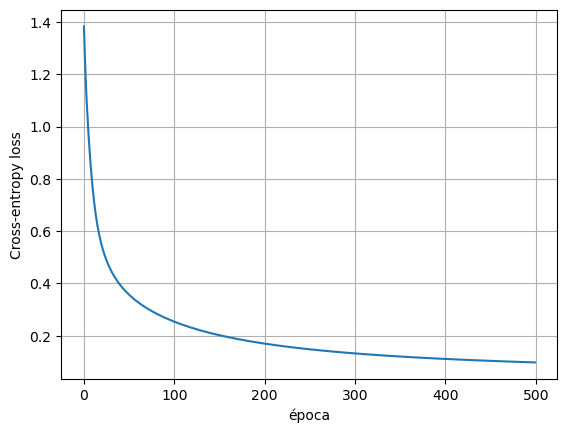

In [21]:
plt.plot(loss)
plt.grid(True)
plt.xlabel("época")
plt.ylabel("Cross-entropy loss")
plt.show()

In [22]:
preds_train = model.predict(x_train).numpy()
preds_test = model.predict(x_test).numpy()

In [23]:
print("Accuracy (train):", model.accuracy(x_train, t_train))
print("Accuracy (test):", model.accuracy(x_test, t_test))

Accuracy (train): 0.98
Accuracy (test): 0.94


### <font color="#CA3532">Visualización del modelo</font>

(1763, 3)


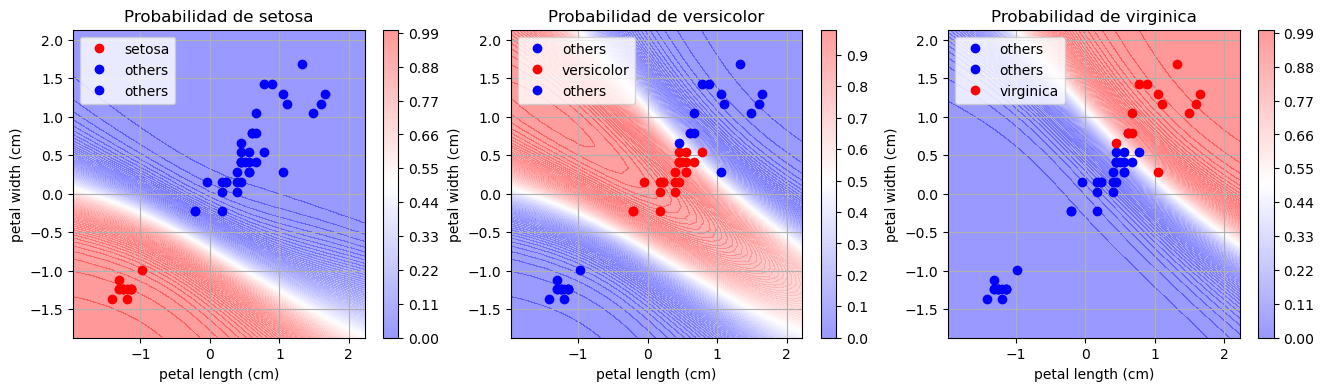

In [24]:
xx, yy = np.meshgrid(np.arange(x_train[:, 0].min()-0.5, x_train[:, 0].max()+0.5, 0.1),
                     np.arange(x_train[:, 1].min()-0.5, x_train[:, 1].max()+0.5, 0.1))
xy = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])],axis=0).T
z = model.predict(xy).numpy()
print(z.shape)

plt.figure(figsize=(16, 4))

for clase_objetivo in [0, 1, 2]:
  plt.subplot(1, 3, clase_objetivo+1)
  plt.contourf(xx, yy, z[:, clase_objetivo].reshape(xx.shape), 100, cmap="bwr", alpha=0.4, vmin=0.0, vmax=1.0)

  plt.plot(x_test[t_test.ravel()==0, 0], x_test[t_test.ravel()==0, 1], 'o', label=iris.target_names[0] if clase_objetivo == 0 else 'others', color='red' if clase_objetivo == 0 else 'blue')
  plt.plot(x_test[t_test.ravel()==1, 0], x_test[t_test.ravel()==1, 1], 'o', label=iris.target_names[1] if clase_objetivo == 1 else 'others', color='red' if clase_objetivo == 1 else 'blue')
  plt.plot(x_test[t_test.ravel()==2, 0], x_test[t_test.ravel()==2, 1], 'o', label=iris.target_names[2] if clase_objetivo == 2 else 'others', color='red' if clase_objetivo == 2 else 'blue')

  plt.title("Probabilidad de %s" % (iris.target_names[clase_objetivo]))
  plt.xlabel(iris.feature_names[pair[0]])
  plt.ylabel(iris.feature_names[pair[1]])
  plt.grid(True)

  plt.legend(loc=2)
  plt.colorbar()

plt.show()

## ¿Y si ahora intentamos hacer selección de atributos o explicabilidad de la red neuronal?

Representemos una red neuronal completa con Graphviz.

In [72]:
from graphviz import Digraph

def draw_network(inputs, hidden, outputs, color_input=None):
    # Crear un grafo dirigido
    dot = Digraph(comment='Ejemplo de Grafo Dirigido')
    dot.attr(rankdir='LR')

    # Agregar nodos
    for i in range(inputs):
        if color_input == i+1:
            dot.node('x'+str(i+1), 'x'+str(i+1), color="red")
            dot.node("i"+str(i+1), "", shape="point", style='invis')
            dot.edge("i"+str(i+1), "x"+str(i+1), color="red")
        else:
            dot.node('x'+str(i+1), 'x'+str(i+1))
            dot.node("i"+str(i+1), "", shape="point", style='invis')
            dot.edge("i"+str(i+1), "x"+str(i+1))
        
    for i in range(hidden):
        dot.node('h'+str(i+1), 'h'+str(i+1))
        
    for i in range(outputs):
        dot.node('y'+str(i+1), 'y'+str(i+1))
        dot.node("o"+str(i+1), "", shape="point", style='invis')
        dot.edge("y"+str(i+1), "o"+str(i+1))

    for i in range(inputs):
        for j in range(hidden):
            for k in range(outputs):
                dot.edge('h'+str(j+1), 'y'+str(k+1))
            if color_input == i+1:
                dot.edge("x"+str(i+1), "h"+str(j+1), color="red")
            else:
                dot.edge("x"+str(i+1), "h"+str(j+1))

    return dot

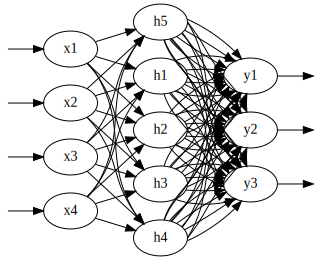

In [26]:
draw_network(4, 5, 3)

La salida de este modelo está definida como:

$$\mathbf{z}^h = \mathbf{x} \mathbf{W}^h + \mathbf{b}^h$$

$$\mathbf{h} = f(\mathbf{z}^h)$$

$$\mathbf{z}^y = \mathbf{h} \mathbf{W}^y + \mathbf{b}^y$$

$$y_i = softmax_i(\mathbf{z}^y) = \frac{e^{z_i^y}}{\sum_j e^{z_j^y}}$$

donde $\mathbf{x}$ es el vector de atributos de entrada, $\mathbf{W}^h$ y $\mathbf{W}^y$ son las matrices de pesos, y $\mathbf{b}^h$ y $\mathbf{b}^y$ son los vectores de *bias* de cada capa. Así, el vector $\mathbf{y}$ representa la probabilidad asignada del modelo a cada una de las clases.

In [67]:
# Cargo de nuevo el dataset
iris = load_iris()
x = iris.data
t = iris.target

np.random.seed(42)
p = np.random.permutation(len(x))
x = x[p, :]
t = t[p][:, None]
print(x.shape, t.shape)

# Particion entrenamiento-test:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.33, random_state=42)

# NO ME OLVIDO DE NORMALIZAR PARA EXPLICAR
medias = x_train.mean(axis=0, keepdims=True)
stds = x_train.std(axis=0, keepdims=True)
x_train = (x_train-medias)/stds
x_test = (x_test-medias)/stds

(150, 4) (150, 1)


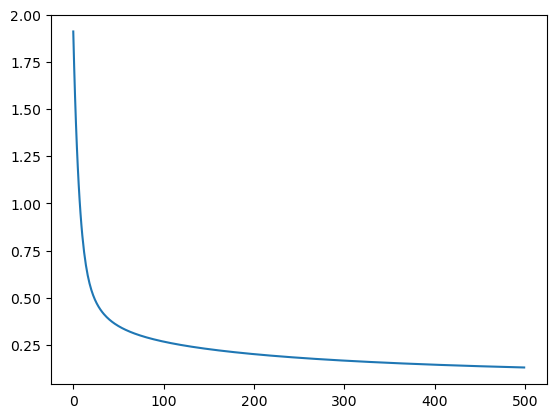

In [68]:
nepocas = 500
eta = 0.1

model = NeuralNetworkModel([4, 20, 3])

loss = model.fit(x_train, t_train, eta, nepocas)
plt.plot(loss)

In [70]:
model.accuracy(x_train, t_train)

0.96

In [71]:
model.accuracy(x_test, t_test)

0.98

### Hagamos selección de atributos según los pesos

Intentemos hacer selección de atributos según los pesos de la red...

Esperad. Ahora no tenemos una matriz de pesos $\mathbf{W}$, sino que tenemos **dos matrices** $\mathbf{W}^h$ y $\mathbf{W}^y$. ¿Qué hacemos?

Vamos a pensar... Una entrada está conectada a muchas neuronas en la capa oculta.

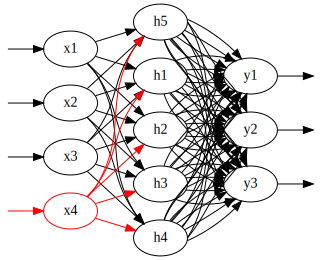

In [74]:
draw_network(4, 5, 3, color_input=4)

¿Y si consideramos la suma de pesos como **cómo influye la entrada en total a todas las neuronas de la capa oculta**?

$$R_{xi} = \sum_j |W^h_{ij}|$$

Esto se conoce como **relevancia global de los atributos de entrada según los pesos en valor absoluto**. Nos ayuda a entender cómo cada entrada influye en general en el modelo.

In [81]:
def global_relevance(model):
    w = model.W[0]
    R = np.abs(w).sum(axis=1)
    return R

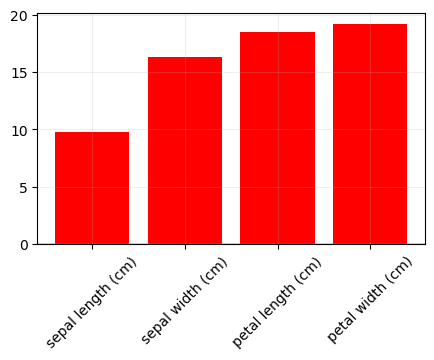

In [84]:
R = global_relevance(model)

plt.figure(figsize=(5, 3))
plt.bar(range(x_train.shape[1]), R, color="red")
plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
plt.grid(alpha=0.2)
plt.axhline(0.0, color="gray", alpha=0.3)
plt.show()

**Recordad que no hemos añadido regularización. Aún no sabemos cómo hacerlo en Tensorflow.**

El próximo día empezaremos con `Keras` y podremos probar qué pasa con la regularización. Además, podremos ver cómo explicar una red neuronal en el notebook `99_01_explicabilidad_redes_neuronales`.